# MCMC with LightCones

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from py21cmmc.mcmc import analyse
from py21cmmc import mcmc

%load_ext autoreload
%autoreload 2

In this tutorial we demonstrate how to do MCMC with a lightcone, to fit just two astrophysical parameters without noise, and then visualise the results. This tutorial follows a very similar pattern to the MCMC intro, and you should follow that one first.

In [2]:
import py21cmmc
py21cmmc.__version__

'0.1.0'

## Running MCMC

To perform an MCMC on a lightcone is *very* similar to a Coeval cube. Merely use the ``CoreLightConeModule`` as the core module, and the ``Likelihood1DPowerLightcone`` as the likelihood. One extra parameter to the ``core`` is available -- ``max_redshift``, which specifies the approximate upper limit on the lightcone's depth. Note that this does **not** necessarily specify the maximum redshift at which the ionization will be computed (this is specified by ``z_heat_max``), it merely specifies where to start saving the ionization boxes into a lightcone. 

Furthermore, one extra parameter to the likelihood is available -- ``nchunks`` -- which allows to break the full lightcone up into independent chunks for which the power spectrum will be computed.

Thus, for example:

In [3]:
core = mcmc.CoreLightConeModule( # All core modules are prefixed by Core* and end with *Module
    redshift = 7.0,              # Lower redshift of the lightcone
    max_redshift = 9.0,          # Approximate maximum redshift of the lightcone (will be exceeded).
    user_params = dict(       
        HII_DIM = 50,         
        BOX_LEN = 125.0
    ),
    z_step_factor=1.04,          # How large the steps between evaluated redshifts are (log).
    z_heat_max=18.0,             # Completely ineffective since no spin temp or inhomogeneous recombinations.
    regenerate=False          
) # For other available options, see the docstring.

# Now the likelihood...
datafiles = ["data/lightcone_mcmc_data_%s.npz"%i for i in range(4)]
likelihood = mcmc.Likelihood1DPowerLightcone(  # All likelihood modules are prefixed by Likelihood*
    datafile = datafiles,        # All likelihoods have this, which specifies where to write/read data
    logk=False,                 # Should the power spectrum bins be log-spaced?
    min_k=0.1,                  # Minimum k to use for likelihood
    max_k=1.0,                  # Maximum ""
    nchunks = 4,                 # Number of chunks to break the lightcone into
    simulate=True
) # For other available options, see the docstring

Actually run the MCMC:

In [4]:
model_name = "LightconeTest"

chain = mcmc.run_mcmc(
    core, likelihood,        # Use lists if multiple cores/likelihoods required. These will be eval'd in order.
    datadir='data',          # Directory for all outputs
    model_name=model_name,   # Filename of main chain output
    params=dict(             # Parameter dict as described above.
        HII_EFF_FACTOR = [30.0, 10.0, 50.0, 3.0],
        ION_Tvir_MIN = [4.7, 2, 8, 0.1],
    ), 
    walkersRatio=3,         # The number of walkers will be walkersRatio*nparams
    burninIterations=0,      # Number of iterations to save as burnin. Recommended to leave as zero.
    sampleIterations=100,    # Number of iterations to sample, per walker.
    threadCount=6,           # Number of processes to use in MCMC (best as a factor of walkersRatio)
    continue_sampling=False  # Whether to contine sampling from previous run *up to* sampleIterations.
)

INFO:cosmoHammer:Using CosmoHammer 0.6.1
INFO:cosmoHammer:Using emcee 2.2.1
INFO:cosmoHammer:all burnin iterations already completed
INFO:cosmoHammer:Sampler: <class 'py21cmmc.mcmc.cosmoHammer.CosmoHammerSampler.CosmoHammerSampler'>
configuration: 
  Params: [30.   4.7]
  Burnin iterations: 0
  Samples iterations: 100
  Walkers ratio: 3
  Reusing burn in: True
  init pos generator: SampleBallPositionGenerator
  stop criteria: IterationStopCriteriaStrategy
  storage util: <py21cmmc.mcmc.cosmoHammer.storage.HDFStorageUtil object at 0x7f65b405b710>
likelihoodComputationChain: 
Core Modules: 
  CoreLightConeModule
Likelihood Modules: 
  Likelihood1DPowerLightcone

INFO:cosmoHammer:start sampling after burn in
INFO:cosmoHammer:Iteration finished:10
INFO:cosmoHammer:Iteration finished:20
INFO:cosmoHammer:Iteration finished:30
INFO:cosmoHammer:Iteration finished:40
INFO:cosmoHammer:Iteration finished:50
INFO:cosmoHammer:Iteration finished:60
INFO:cosmoHammer:Iteration finished:70
INFO:cosmoHa

## Analysis

### Accessing chain data

Access the samples object within the chain (see the intro for more details):

In [5]:
samples = chain.samples

### Trace Plot

Often, for diagnostic purposes, the most useful plot to start with is the trace plot. This enables quick diagnosis of burnin time and walkers that haven't converged. The function in ``py21cmmc`` by default plots the log probability along with the various parameters that were fit. It also supports setting a starting iteration, and a thinning amount. 

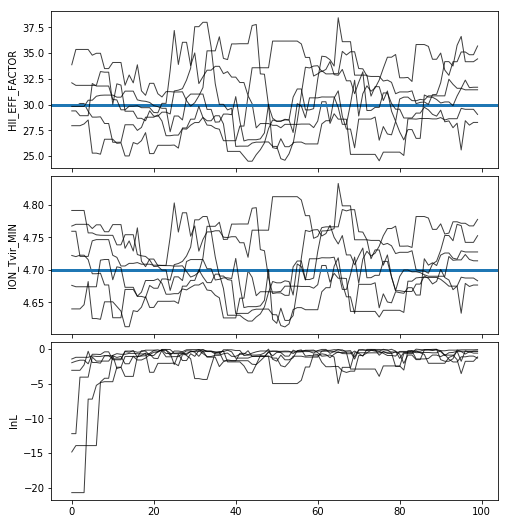

In [6]:
analyse.trace_plot(samples, include_lnl=True, start_iter=0, thin=1, colored=False, show_guess=True);

### Corner Plot

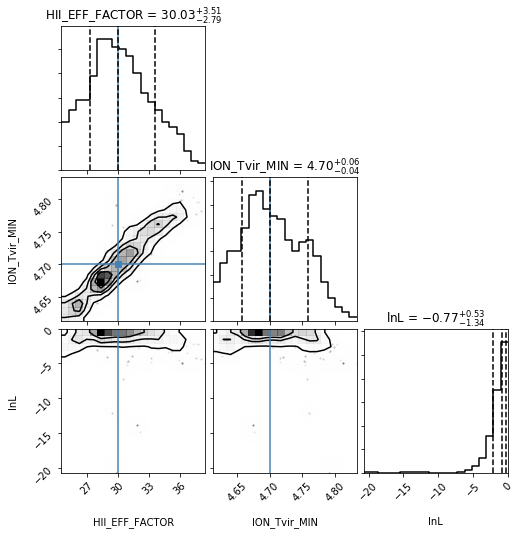

In [7]:
analyse.corner_plot(samples);

### Model Comparison Plot

Extract all blob data from the samples:

In [8]:
blobs = samples.get_blobs()

Read in the data:

In [9]:
delta_data = [d['delta'] for d in likelihood.data]
k_data = [d['k'] for d in likelihood.data]

Now, let's define a function which will plot our model comparison:

In [10]:
def model_compare_plot(samples, k_data, delta_data, thin=1, start_iter=0):
    chain = samples.get_chain(thin=thin, discard=start_iter, flat=True)
    blobs = samples.get_blobs(thin=thin, discard=start_iter, flat=True)
    
    ks = [blobs[name] for name in samples.blob_names if name.startswith("k")]
    models = [blobs[name] for name in samples.blob_names if name.startswith("delta")]
    
    fig, ax = plt.subplots(1, len(ks), sharex=True, sharey=True, figsize=(5*len(ks), 4.5), 
                          subplot_kw={"xscale":'log', "yscale":'log'}, gridspec_kw={"hspace":0.05, 'wspace':0.05},
                          squeeze=False)

    for i,(k,model, kd, data) in enumerate(zip(ks,models, k_data, delta_data)):
        label="models"

        for pp in model:
            ax[0,i].plot(k[0], pp, color='k', alpha=0.2, label=label, zorder=1)
            if label:
                label=None

        mean = np.mean(model, axis=0)
        std = np.std(model, axis=0)
        md = np.median(model, axis=0)

        ax[0,i].fill_between(k[0], mean - std, mean+std, color="C0", alpha=0.6)
        ax[0,i].plot(k[0], md, color="C0", label="median model")

        ax[0,i].errorbar(kd, data, yerr = (0.15*data), color="C1", 
                     label="data", ls="None", markersize=5, marker='o')

        ax[0,i].set_xlabel("$k$ [Mpc$^{-3}$]", fontsize=15)
        ax[0,i].text(0.5, 0.86, "Chunk %s"%i, transform=ax[0,i].transAxes, fontsize=15, fontweight='bold')

    ax[0,0].legend(fontsize=12)
    #plt.ylim((3.1e2, 3.5e3))


    ax[0,0].set_ylabel("$k^3 P$", fontsize=15)

#plt.savefig(join(direc, modelname+"_power_spectrum_plot.pdf"))

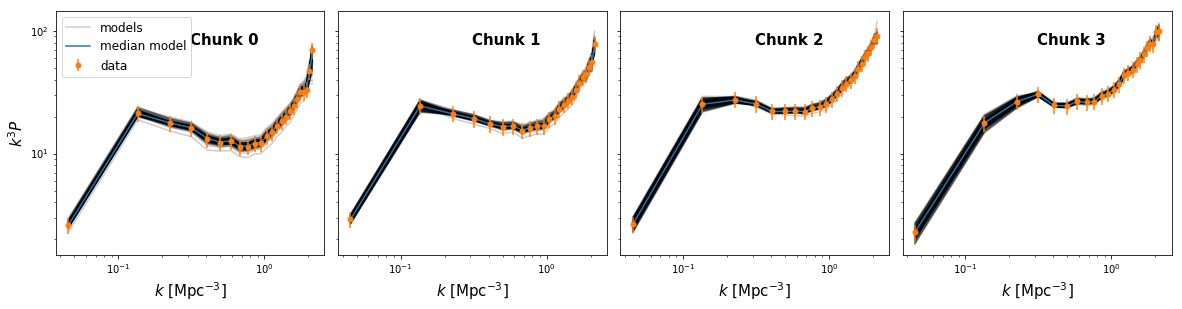

In [11]:
model_compare_plot(samples, k_data, delta_data, thin=5)